# Power Calculation

To estimate the power of detecting static functional connectivity (FC) alterations in Autism Spectrum Disorder (ASD), I adapted the power demo code from Koen Helwegen (https://github.com/dutchconnectomelab/power-demo/blob/main/setup.py). The power demo accompanies their paper on Statistical power in network neuroscience: https://doi-org.portail.psl.eu/10.1016/j.tics.2022.12.011.
The main adaptations are:
1. Removed Case 2 for structural connectivity.
2. Using FDR method to determine the significance level (alpha) instead of Bonferroni.
3. Running the script for networks rather than edges ij and uv.

In [1]:
# Import necessary packages and modules.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats import power as smpower
from pandas.core.computation.check import NUMEXPR_INSTALLED

import pinn

# Set pretty print
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

#### Functions

In [2]:
def tt_critical_effect_size(sample_size: int, alpha: float = 0.05) -> float:
    """Find the smallest effect size (Cohen's d) that is still significant in a two-tailed ttest."""
    return tt_ind_solve_power(nobs1=sample_size, alpha=alpha, power=0.8, reliability=0.5)

def tt_ind_solve_power(
    effect_size=None,
    nobs1=None,
    alpha=None,
    power=None,
    reliability=1,
    **kwargs,
):
    """Wrapper of statsmodels.stats.power.tt_ind_solve_power with reliability correction"""
    if not (0 <= reliability <= 1):
        raise ValueError(
            f"Reliability score should lie in [0,1], instead got {reliability}."
        )

    if effect_size is not None:
        return smpower.tt_ind_solve_power( # Default is two-sided t-test. Outputs the parameter which is set to None.
            effect_size=effect_size * np.sqrt(reliability), # Correction for measurement error in the data
            nobs1=nobs1,
            alpha=alpha,
            power=power,
            **kwargs,
        )
    else:
        return smpower.tt_ind_solve_power(
            nobs1=nobs1,
            alpha=alpha,
            power=power,
            **kwargs,
        ) / np.sqrt(reliability)

# Algorithm to estimate power. It will return power if that's the only required parameter set to None.
def measurement_error():
    powers = []
    for ix, row in df_get_power.iterrows():

        # Extract values effect_size, sample_size, alpha, and reliability from the current row
        effect_size_data = row["cohen_d"]
        sample_size_data = row['sample_size']
        alpha_data = row['alpha']
        reliability_data = row['reliability']
#         print(f"Effect Size: {effect_size}, Sample Size: {sample_size}, Alpha: {alpha}, Reliability: {reliability}")

        #Call the function tt_ind_solve_power with the extracted values
        edge_power = tt_ind_solve_power(effect_size=effect_size_data, 
                                        nobs1=sample_size_data, 
                                        alpha=alpha_data, 
                                        power=None,
                                        reliability=reliability_data)
        powers.append(edge_power)
    return powers

# Perform power simulation based on effect size, reliability, and significance level.
def monte_carlo_power(
    mean_controls,
    mean_patients,
    sample_size,
    alpha,
    rm_zeros=None,
    iterations=10_000,
    edge_generator=None,
):
    """Estimate power for edgewise comparison with missing values.

    Args:
      mean_controls: mean edge weight for the control group
      mean_patients: mean edge weight for the patient group
      sample_size: number of observations per group
      alpha: significance threshold
      rm_zeros: whether or not to remove missing values before inference
      iterations: number of simulated studies used to estimate power
      edge_generator: function used to generate edges. Should accept arguments `sample_size` and `mean`

    Return power (ratio of studies in which null hypothesis was correctly rejected)
    """
    # The main loop, simulating studies while keeping
    # track of how many are successful.
    detection_count = 0
    for _ in range(iterations):
        edges_controls = edge_generator(sample_size=sample_size, mean=mean_controls)
        edges_patients = edge_generator(sample_size=sample_size, mean=mean_patients)

        if rm_zeros:
            edges_controls = edges_controls[edges_controls != 0]
            edges_patients = edges_patients[edges_patients != 0]

        # we count a detection as successful if it is significant (at alpha)
        # and in the right direction
        if (ttest_ind(edges_controls, edges_patients)[1] < alpha) and (
            np.sign(np.mean(edges_controls) - np.mean(edges_patients))
            == np.sign(mean_controls - mean_patients)
        ):
            detection_count += 1

    # our power estimation is simply the ratio of successful studies
    return detection_count / iterations

### Effect size, reliability, and alpha

Specify the required information for edge-level power computation: 
- effect size, 
- significance level,
- power, and 
- degree of measurement error (rho).

Define also the **ratio missing** (only relevant for section Other).

We'll use the FDR approach to correct for family-wise error rates, which means that alpha is set to 0.05. If we would use Bonferroni method, we would have to divide alpha with the number of multiple comparisons. The conventional power for neuroimaging studies is 0.8.

In [3]:
# Specify the path to the file with the required data collected from the systematic search
file_path = "Meta-Analysis-Static-FC.xlsx"

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name='data')  # Change 'data' to the actual sheet name if it's different

# display(df)

In [4]:
# Extract only the columns needed for power computation and plotting
columns = ["paper_shortname","ABIDE", "age_cat", "age", "effect_type", "cohen_d",
           "sample_size", "alpha", "power", "reliability"]

df_get_power = df[columns]

# Turn Cohen's d into float
df_get_power.loc[:, 'cohen_d'] = df_get_power['cohen_d'].astype(float)

display(df_get_power)

,paper_shortname,ABIDE,age_cat,age,effect_type,cohen_d,sample_size,alpha,power,reliability
0,Rolison_2022_c,no,infant,0.90,FC_static,0.69,46,0.050,NaN,1.000
1,Rolison_2022_d,no,infant,0.90,FC_static,0.79,33,0.050,NaN,1.000
2,Rolison_2022_c,no,infant,0.90,FC_static,0.67,46,0.050,NaN,1.000
3,Rolison_2022_d,no,infant,0.90,FC_static,0.96,33,0.050,NaN,1.000
4,Rolison_2022_d,no,infant,0.90,FC_static,1.13,33,0.050,NaN,1.000
5,Xiao_2023,no,toddler,2.30,FC-phenotype,1.54,86,0.050,NaN,1.000
6,Xiao_2023,no,toddler,2.30,FC-phenotype,1.155,86,0.050,NaN,1.000
7,Xiao_2023,no,toddler,2.30,FC-phenotype,1.155,86,0.050,NaN,1.000
8,Xiao_2023,no,toddler,2.30,FC-phenotype,1.317,86,0.050,NaN,1.000
9,Xiao_2023,no,toddler,2.30,FC-phenotype,1.283,86,0.050,NaN,1.000


### Edge-level power computation

Calculate the power of studies that report effect sizes of static functional connectivity alterations in Autism Spectrum Disorder (ASD). The studies considered are based on a systematic search of the literature.

In [5]:
power_result = measurement_error()

# Add the calculated power to the dataframe
df_get_power.loc[:, "power"] = power_result

display(df_get_power)

,paper_shortname,ABIDE,age_cat,age,effect_type,cohen_d,sample_size,alpha,power,reliability
0,Rolison_2022_c,no,infant,0.90,FC_static,0.69,46,0.050,0.906,1.000
1,Rolison_2022_d,no,infant,0.90,FC_static,0.79,33,0.050,0.885,1.000
2,Rolison_2022_c,no,infant,0.90,FC_static,0.67,46,0.050,0.889,1.000
3,Rolison_2022_d,no,infant,0.90,FC_static,0.96,33,0.050,0.970,1.000
4,Rolison_2022_d,no,infant,0.90,FC_static,1.13,33,0.050,0.995,1.000
5,Xiao_2023,no,toddler,2.30,FC-phenotype,1.54,86,0.050,1.000,1.000
6,Xiao_2023,no,toddler,2.30,FC-phenotype,1.155,86,0.050,1.000,1.000
7,Xiao_2023,no,toddler,2.30,FC-phenotype,1.155,86,0.050,1.000,1.000
8,Xiao_2023,no,toddler,2.30,FC-phenotype,1.317,86,0.050,1.000,1.000
9,Xiao_2023,no,toddler,2.30,FC-phenotype,1.283,86,0.050,1.000,1.000


## Results

### Summary Statistics

In [6]:
## ---------------------- ALL STUDIES ---------------------- ##
# Get the mean power
mean_power_all = np.mean(power_result) * 100
mean_power_static_FC_ASD = np.mean(df_get_power[df_get_power['effect_type'] == 'FC_static']['power']) * 100
mean_power_static_FC_symptoms = np.mean(df_get_power[df_get_power['effect_type'] == 'FC-phenotype']['power']) * 100

# Get the mean effect sizes
mean_effect_size_all = round(np.mean(df_get_power['cohen_d']), 2)
mean_effect_size_static_FC_ASD = round(np.mean(df_get_power[df_get_power['effect_type'] == 'FC_static']['cohen_d']), 2)
mean_effect_size_static_FC_symptoms = round(np.mean(df_get_power[df_get_power['effect_type'] == 'FC-phenotype']['cohen_d']), 2)

# Create tables as lists of dictionaries
data = {
    "Study Type": ["All findings", "Static FC in ASD", "Static FC correlation to ASD symptoms"],
    "Mean Edge Power": [f"{mean_power_all:.2f}%", f"{mean_power_static_FC_ASD:.2f}%", f"{mean_power_static_FC_symptoms:.2f}%"],
    "Mean Effect Size": [mean_effect_size_all, mean_effect_size_static_FC_ASD, mean_effect_size_static_FC_symptoms]
}

# Create DataFrame
df_summary_power_effect_size_all = pd.DataFrame(data)

# Save DataFrame to CSV
df_summary_power_effect_size_all.to_csv('summary_all_studies_power_effect_size.csv', index=False)
display(df_summary_power_effect_size_all)

,Study Type,Mean Edge Power,Mean Effect Size
0,All findings,99.27%,0.72
1,Static FC in ASD,98.99%,0.44
2,Static FC correlation to ASD symptoms,99.30%,0.85


In [7]:
## ---------------------- PER STUDY ---------------------- ##
# Get mean power & effect size per study
unique_paper_shortnanames = np.unique(df['paper_shortname'])

# Initialize lists to store mean power and mean effect size per study
mean_powers = []
mean_effect_sizes = []
study_weights = []

for study in unique_paper_shortnanames:
       
    # Get subset DataFrame for the current study
    study_subset = df_get_power[df_get_power['paper_shortname'] == study]

    # Count the number of times a study appears (this will be the weight)
    study_weight = len(study_subset)

    # Compute mean edge power and mean effect size
    mean_power       = np.mean(study_subset['power']) * 100
    mean_effect_size = round(np.mean(study_subset['cohen_d']), 2)

    # Append mean power, mean effect size, and study weigth to lists
    mean_powers.append(mean_power)
    mean_effect_sizes.append(mean_effect_size)
    study_weights.append(study_weight)
    
# Create DataFrame for mean powers and mean effect sizes
data = {
    "Study": unique_paper_shortnanames,
    "Mean Edge Power": mean_powers,
    "Mean Effect Size": mean_effect_sizes,
    "Weight": study_weights
}
df_summary_power_effect_size_ind = pd.DataFrame(data)

# Save DataFrame to CSV
df_summary_power_effect_size_ind.to_csv('summary_per_study_power_effect_size.csv', index=False)
display(df_summary_power_effect_size_ind)

,Study,Mean Edge Power,Mean Effect Size,Weight
0,Chen_2021,99.931,1.13,7
1,Chen_2022,80.546,0.15,1
2,Du_2021,100.000,0.39,1
3,Lan_2022,100.000,0.81,3
4,Nagai_2023,99.775,0.84,1
5,Oblong_2023,99.252,0.74,3
6,Ren_2023_a,100.000,0.40,16
7,Ren_2023_b,100.000,0.58,3
8,Rolison_2022_a,99.955,0.39,7
9,Rolison_2022_c,89.703,0.68,2


In [8]:
## ---------------------- PER AGE GROUP ---------------------- ##
# Get mean age, effect size, and power per age category

df_summary_per_age = df_get_power.groupby("age_cat").agg({
    'age': 'mean',        # Calculate mean age
    'cohen_d': 'mean',    # Calculate mean effect size (cohen_d)
    'power': 'mean'       # Calculate mean power
}).reset_index()

# Display
display(df_summary_per_age)

# Save DataFrame to CSV
df_summary_per_age.to_csv('summary_per_age_power_effect_size.csv', index=False)

,age_cat,age,cohen_d,power
0,adult,27.559,1.215,1.000
1,infant,0.900,0.848,0.929
2,preschool,5.476,1.129,0.999
3,school,10.822,0.64,0.998
4,teen,16.249,0.413,0.990
5,toddler,2.300,1.354,1.000
6,young_adult,20.705,0.593,0.946


In [9]:
## ---------------------- PER SOURCE OF DATA (ABIDE OR NOT) ---------------------- ##
# Get mean age, effect size, and power per source of data (ABIDE: yes/no)

df_summary_per_ABIDE = df_get_power.groupby("ABIDE").agg({
    'age': 'mean',        # Calculate mean age
    'cohen_d': 'mean',    # Calculate mean effect size (cohen_d)
    'power': 'mean'       # Calculate mean power
}).reset_index()

# Display
display(df_summary_per_ABIDE)

# Save DataFrame to CSV
df_summary_per_ABIDE.to_csv('summary_per_ABIDE_power_effect_size.csv', index=False)

,ABIDE,age,cohen_d,power
0,no,15.609,1.166,0.996
1,yes,15.041,0.457,0.991


### Plotting

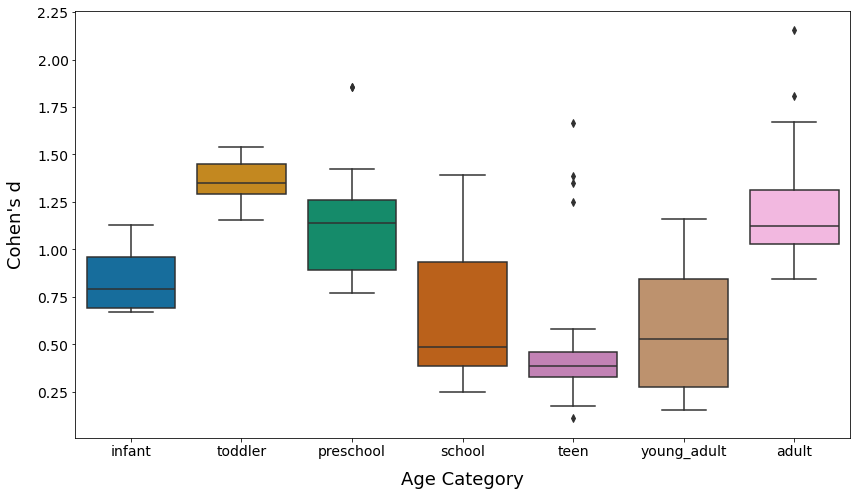

In [10]:
# Box plot of effect sizes per age group
plt.figure(figsize=(12,7))

sns.boxplot(x="age_cat", y="cohen_d", data=df_get_power, palette="colorblind")

plt.xlabel("Age Category", fontsize=18, labelpad=12)
plt.ylabel("Cohen's d", fontsize=18, labelpad=12)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

# plt.title("Cohen's d by Age Category", fontsize=20, y=1.02)

plt.savefig("Mean_effect_size_per_age.png")
plt.tight_layout()
plt.show()

### Edge-level sample size computation

In [11]:
# Calculate the min. effect size given a sample size
max_sample = 50
min_effect_size = tt_critical_effect_size(sample_size=max_sample)

print(f"The minimum effect size for sample size {max_sample} is {round(min_effect_size, 2)}.")

The minimum effect size for sample size 50 is 0.8.


In [12]:
# Run the algorithm to estimate sample size. It returns sample size (nobs1) because it's the only parameter set to None.
# Note that the estimate of the sample size is per group for a two-sample independent t-test design.
alpha_FDR = 0.05
power_convention = 0.8
rho = 0.8
    
sample_size_all = tt_ind_solve_power(effect_size=mean_effect_size_all, alpha=alpha_FDR, 
                                     power=power_convention, reliability=rho)
sample_size_static_FC = tt_ind_solve_power(effect_size=mean_effect_size_static_FC_ASD, alpha=alpha_FDR,
                                           power=power_convention, reliability=rho)
sample_size_static_FC_symptoms = tt_ind_solve_power(effect_size=mean_effect_size_static_FC_symptoms, alpha=alpha_FDR,
                                                    power=power_convention, reliability=rho)
# Define the data
data = {
    "Reliability": [rho, rho, rho],
    "Power": [power_convention, power_convention, power_convention],
    "Mean Effect Size": [mean_effect_size_all, mean_effect_size_static_FC_ASD, mean_effect_size_static_FC_symptoms],
    "Min Sample Size": [round(sample_size_all), round(sample_size_static_FC), round(sample_size_static_FC_symptoms)]
}

# Define the column names
effect_types = ["All studies", "Static FC in ASD", "Static FC correlation to ASD symptoms"]

# Create DataFrame
df_summary_sample_sizes = pd.DataFrame(data, index=effect_types)

# Save DataFrame to CSV
df_summary_sample_sizes.to_csv('summary_sample_sizes.csv')
display(df_summary_sample_sizes)

,Reliability,Power,Mean Effect Size,Min Sample Size
All studies,0.8,0.8,0.72,39
Static FC in ASD,0.8,0.8,0.44,102
Static FC correlation to ASD symptoms,0.8,0.8,0.85,28


In [13]:
alpha_FDR = 0.05
power_convention = 0.8
reliabilities = np.arange(0.1, 1.1, 0.1)

SS_ALL = []
SS_STATIC_FC = []
SS_STATIC_FC_SYMPTOMS = []

for r in reliabilities: 
    SS_all = tt_ind_solve_power(effect_size=mean_effect_size_all, alpha=alpha_FDR, 
                                         power=power_convention, reliability=r)
    SS_static_FC = tt_ind_solve_power(effect_size=mean_effect_size_static_FC_ASD, alpha=alpha_FDR,
                                               power=power_convention, reliability=r)
    SS_static_FC_symptoms = tt_ind_solve_power(effect_size=mean_effect_size_static_FC_symptoms, alpha=alpha_FDR,
                                                        power=power_convention, reliability=r)
    SS_ALL.append(SS_all)
    SS_STATIC_FC.append(SS_static_FC)
    SS_STATIC_FC_SYMPTOMS.append(SS_static_FC_symptoms)

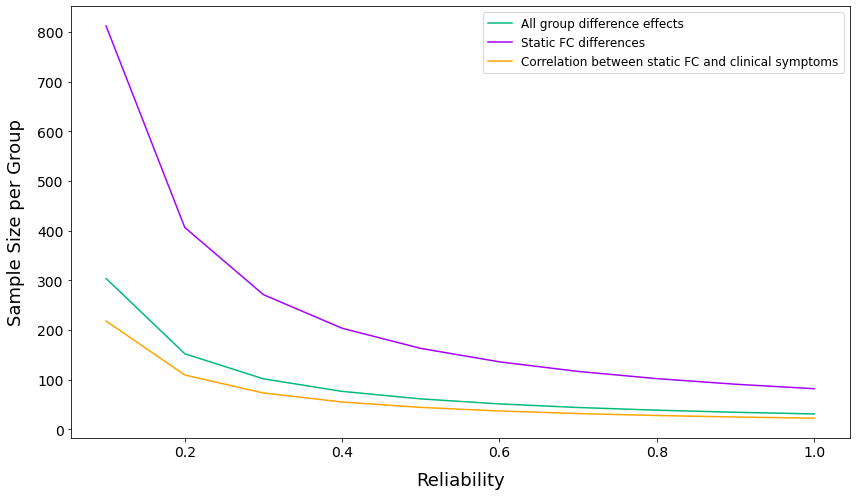

In [14]:
# Plot Min Sample Size for varying Reliabilities
plt.figure(figsize=(12,7))
plt.plot(reliabilities, SS_ALL, color='#00ba77', label="All group difference effects")
plt.plot(reliabilities, SS_STATIC_FC, color='#A500FF', label="Static FC differences")
plt.plot(reliabilities, SS_STATIC_FC_SYMPTOMS, color='#ffa500', label="Correlation between static FC and clinical symptoms")

plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xlabel("Reliability", fontsize=18, labelpad=12)
plt.ylabel("Sample Size per Group", fontsize=18, labelpad=12)
# plt.title("Minimal Sample Size Depends on Reliability", fontsize=20, y=1.02)

plt.legend(fontsize='large')

plt.tight_layout()
plt.savefig("Min-sample-size-over-reliabilities.png")
plt.show()

### Simulation

In [15]:
def box5_zeros():
    effect_size = 0.59
    mean_controls = 0.53 # Mean controls is the mean edge weight for the control group.
    sample_size = int(sample_size_static_FC)
    alpha = 0.05

    print("\n## CASE 1: Thresholding functional connectivity ##")

    # For simplicity we simply use a standard normal distribution;
    # this allows us to directly use the Cohen's d effect size
    def thresholded_edges(sample_size, mean=0):
        edges = mean + np.random.randn(sample_size)
        edges[edges < 0] = 0  # remove negative edges
        return edges

    print(
        f"Running simulations with effect size d = {effect_size}, sample size = {sample_size} and alpha = {alpha:.6f}."
    )

    print(
        f"In controls, about {np.mean(thresholded_edges(1_000_000, mean_controls) == 0)*100:.0f}% of edges are thresholded."
    )

    power_with_zeros = monte_carlo_power(
        mean_controls,
        mean_controls - effect_size,
        sample_size=sample_size,
        alpha=alpha,
        rm_zeros=False,
        edge_generator=thresholded_edges,
    )

    power_without_zeros = monte_carlo_power(
        mean_controls,
        mean_controls - effect_size,
        sample_size=sample_size,
        alpha=alpha,
        rm_zeros=True,
        edge_generator=thresholded_edges,
    )

    print(f"Power when retaining zeros: {power_with_zeros*100:.2f}%.")
    print(f"Power when removing zeros: {power_without_zeros*100:.2f}%.")

    print("\n## Effective sample size and power ##")
    ratio_missing = 0.3
    
    print(f"Evaluating power for effect size d = {effect_size} and alpha = {alpha:6f}.")
    for s in [sample_size, int(sample_size * (1 - ratio_missing))]:
        print(
            f"Power when sample size = {s}: {tt_ind_solve_power(effect_size, s, alpha)*100:.2f}%"
        )


def box5_topology():
    pass

if __name__ == "__main__":
    measurement_error()
    box5_zeros()
    box5_topology()


## CASE 1: Thresholding functional connectivity ##
Running simulations with effect size d = 0.59, sample size = 102 and alpha = 0.050000.
In controls, about 30% of edges are thresholded.
Power when retaining zeros: 96.17%.
Power when removing zeros: 51.53%.

## Effective sample size and power ##
Evaluating power for effect size d = 0.59 and alpha = 0.050000.
Power when sample size = 102: 98.72%
Power when sample size = 71: 93.71%
